
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 5: $k$-NN Classification, ROC, and PCA

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited.

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 25)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import preprocessing


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import seaborn as sns
sns.set()


## Continuing Cancer Classification from Gene Expressions

In this problem, we will continue to work with the 2-class (ALL vs. AML) cancer classification problem from homework 4. The dataset is provided in the file `data/hw4_enhance.csv` and is the same as the previous HW.  Recall: **0 indicates the ALL** class and **1 indicates the AML** class within `Cancer_type`, and columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will handle the high dimensionality of this problem directly by applying Principal Component Analysis (PCA), and then use the resulting PCA-transformed in logistic regression and $k$-NN modeling.

<div class='exercise'><b> Question 1 [20 pts]: Baseline Modeling </b></div>

First step is to split the observations into an approximate 80-20 train-test split.  Below is the same code from HW4 to do this for you (we again want to make sure everyone has the same splits). Use the training data set to answer the following questions:


**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). `Cancer_type` is again our target column.**

In [5]:
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)

X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

**1.1** Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.

**1.2** Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.

**1.3** Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  Report the classification accuracy on both the train and test sets.

**1.4** Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `k = 1,2,5,10,20,50,100,200,500`. 

**1.5** Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.


<hr>

### Solutions

**1.1 Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.**

In [6]:
X_train_array = X_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_train_array)
normalized_X_train = pd.DataFrame(x_scaled)
normalized_X_train.columns = X_train.columns

In [7]:
X_train_array = X_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_train_array)
normalized_X_train = pd.DataFrame(x_scaled)
normalized_X_train.columns = X_train.columns

X_test_array = X_test.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_test_array)
normalized_X_test = pd.DataFrame(x_scaled)
normalized_X_test.columns = X_test.columns

**1.2 Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.**

In [8]:
lr = LogisticRegression(C=100000000)
lr.fit(X_train, y_train)

y_hat_train_log = lr.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_hat_train_log))

y_hat_test_log = lr.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_hat_test_log))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Accuracy: 1.0
Test Accuracy: 0.7417218543046358


**1.3 Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  eport the misclassification rate on both the train and test sets.**

In [9]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

lasso = Lasso(random_state=0, max_iter=10000)
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(normalized_X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [59]:
coef_dict = {}
for coef, feat in zip(model_lasso.coef_,normalized_X_train.columns):
    coef_dict[feat] = coef


y_hat_train_lasso = model_lasso.predict(normalized_X_train)

y_hat_test_lasso = model_lasso.predict(normalized_X_test)
y_hat_test_lasso_round = np.round(y_hat_test_lasso)
y_hat_test_lasso_round[y_hat_test_lasso_round ==-1] = 0
print("Training Accuracy:", accuracy_score(y_train, np.round(y_hat_train_lasso)))
print("Test Accuracy:", accuracy_score(y_test, y_hat_test_lasso_round))
print("Lasso picked " + str(sum(model_lasso.coef_ != 0)) + 
      " variables and eliminated the other " +  str(sum(model_lasso.coef_ == 0)) + 
      " variables")

Training Accuracy: 0.9750415973377704
Test Accuracy: 0.7549668874172185
Lasso picked 311 variables and eliminated the other 6818 variables


**1.4 Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,2,3,4,5,7,9,10,15,25]`.  Report your chosen $k$, and report the misclassification rate on both the train and test sets for the model using your chosen $k$.**

In [11]:
KNNModels = {}

for k in (1,2,3,4,5,7,9,10,15,25):
    knnreg = KNeighborsRegressor(n_neighbors=k)
    knnreg.fit(normalized_X_train, y_train)
    KNNModels[k] = knnreg # Store the regressors in a dictionary

In [12]:
k_values = [1,2,3,4,5,7,9,10,15,25]
test_r_squared = []
train_r_squared = []

for k in [1,2,3,4,5,7,9,10,15,25]:
    knnreg = (KNNModels[k].fit(normalized_X_train, y_train))
    r2_test = knnreg.score(normalized_X_test, y_test)
    r2_train = knnreg.score(normalized_X_train, y_train)
    test_r_squared.append(r2_test)
    train_r_squared.append(r2_train)
    
df_r2 = pd.DataFrame(list(zip(k_values, test_r_squared, train_r_squared)), 
               columns =['K Value', 'Test R Squared',"Train R Squared"]) 

In [13]:
df_r2 #k=9 is best

,K Value,Test R Squared,Train R Squared
0,1,0.045981,1.000000
1,2,0.350737,0.813528
2,3,0.378710,0.766170
3,4,0.378894,0.727784
4,5,0.407448,0.719759
5,7,0.448897,0.673810
6,9,0.451014,0.655503
7,10,0.446404,0.641108
8,15,0.441722,0.567029
9,25,0.334349,0.437642


In [46]:
knnreg_best = (KNeighborsRegressor(n_neighbors=9).fit(normalized_X_train, y_train))
y_hat_test_knn = knnreg_best.predict(normalized_X_test)

**1.5 Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.**

In [111]:
df_cm

,0,1
0,66,11
1,26,48


In [213]:
def create_confusion_matrix(label, y_test, y_hat_values, plot_value):
    array = confusion_matrix(y_test, np.round(y_hat_values))
    df_cm = pd.DataFrame(array, index = [i for i in '01'],
                      columns = [i for i in "01"])
    print("Classification Report for: " + label)
    print(metrics.classification_report(y_test, np.round(y_hat_values)))

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,plot_value)

    plt.title("Confusion Matrix of Cancer Types: " + label)
    sn.heatmap(df_cm, annot=True)
    plt.xlabel("Correct Class")
    plt.yticks([0,1],['ALL Cancer Type','AML Cancer Type'])
    plt.ylabel("Predicted Class")
    plt.xticks([0,1],['ALL Cancer Type','AML Cancer Type'])


Classification Report for: Logarithmic
              precision    recall  f1-score   support

         0.0       0.72      0.82      0.76        77
         1.0       0.78      0.66      0.72        74

   micro avg       0.74      0.74      0.74       151
   macro avg       0.75      0.74      0.74       151
weighted avg       0.75      0.74      0.74       151

Classification Report for: Lasso
              precision    recall  f1-score   support

         0.0       0.72      0.86      0.78        77
         1.0       0.81      0.65      0.72        74

   micro avg       0.75      0.75      0.75       151
   macro avg       0.77      0.75      0.75       151
weighted avg       0.76      0.75      0.75       151

Classification Report for: KNN
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86        77
         1.0       0.86      0.84      0.85        74

   micro avg       0.85      0.85      0.85       151
   macro avg       0.85  

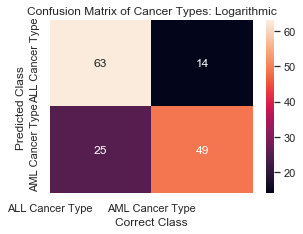

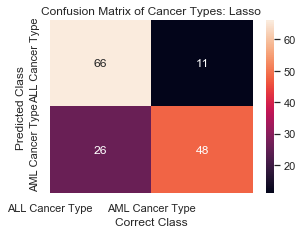

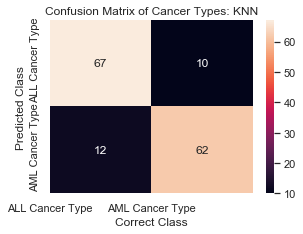

In [214]:
labels = ("Logarithmic",'Lasso','KNN')
y_hat_vals = (y_hat_test_log, y_hat_test_lasso_round, y_hat_test_knn)
nums = [1,2,3]

for x,y,z in zip(labels, y_hat_vals, nums):
    create_confusion_matrix(x,y_test,y,z)

KNN performed the best out of the three models in both the precision and recall. Log and Lasso both performed similarly across false positives and negatives. 

<div class='exercise'><b> Question 2 [20 pts]: Performing Principal Components Analysis </b></div>

**2.1** Create the full PCA decomposition of `X_train` and apply the transformation to both `X_train` and `X_test`.  Report the shape of both of these.  What is the limiting factor for the maximum number of PCA components for this data set? 

**2.2** PCA is often solely used to help in visualizing high-dimensional problems.  Plot the scatterplot of the second PCA vector of train on the $Y$-axis and the first PCA vector of train on the $X$-axis (be sure to denote the classes via different color/markings).  In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.

**2.3** Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).

**2.4** Plot explained variability in the predictors on the $Y$-axis and the PCA component number on the $X$-axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and justify your choice with 1-3 sentences.

<hr>

### Solutions

**2.1 Create the full PCA decomposition of X_train and apply the transformation to both X_train and X_test. Report the shape of both of these. What is the limiting factor for the maximum number of PCA components for this data set?**

In [ ]:
# your code here


*Your answer here*


**2.2 PCA is often solely used to help in visualizing high-dimensional problems. Plot the scatterplot of the second PCA vector on the  𝑌 -axis and the first PCA vector on the  𝑋 -axis (be sure to denote the classes via different color/markings). In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.**

In [ ]:
# your code here


*your answer here*


**2.3 Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).**

In [ ]:
# your code here


**2.4 Plot explained variability in the predictors on the  𝑌 -axis and the PCA component number on the 𝑋 -axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and ustify your choice in 1-3 sentences.**

In [ ]:
#your code here


<div class='exercise'><b> Question 3 [30 pts]: Principal Components Regression (PCR) </b></div>

**3.1** Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?

**3.2** Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`.

**3.3** Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).

**3.4** Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.

**3.5** Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?

<hr>

### Solutions

**3.1 Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set.  How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?**

In [ ]:
# your code here


*your answer here*


**3.2 Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`**.

In [ ]:
# your code here


**3.3 Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).**

*your answer here*

**3.4 Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the best model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.**

In [ ]:
# your code here


*your answer here*

**3.5 Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction? If you were to predict real cancer patients, how would use these models to predict cancer type?**

*your answer here*


<div class='exercise'><b> Question 4: COMPAS [30 points] </b></div>

This problem is unrelated to the first 3 problems, and steps through analyzing the COMPAS data set `compas.csv`.  The variables are roughly explained in the `compas_datadict.csv` file, and ProPublica's analysis is publically available here: https://github.com/propublica/compas-analysis.

**4.1** Split the data into 80% training and 20% test stratified by race. Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.

**4.2** Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.

**4.3** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?  Explain in 3-5 sentences.

**4.4**. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models: $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor. 

**4.5**. Refit the models in 4.4 without race as a predictor.  Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set.  How do these compare to the models when race is included as a predictor?

**4.6**. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.

<hr>

### Solutions

**4.1 Split the data into 80% training and 20% test stratified by race.  Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.**

In [125]:
compas_df = pd.read_csv('data/compas.csv')

train_c, test_c =train_test_split(compas_df, test_size=0.2, 
                                    random_state = 109)



**4.2 Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.**

In [134]:
train_c.head()

,age,c_charge_degree,c_charge_desc,race,score_text,sex,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,two_year_recid,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh
3486,38,M,Felony/Driving Under Influence,Caucasian,Medium,Male,5,0,0,0,5,1,0,0,0,1,0,0,0,0,0,0,0
2839,25,M,Petit Theft,Caucasian,Medium,Male,6,0,0,1,5,1,1,0,0,1,0,0,1,0,0,1,1
4300,33,F,arrest case no charge,Caucasian,Low,Male,1,0,0,0,4,0,3,1,0,0,0,0,0,0,0,0,3
1564,43,M,DUI Property Damage/Injury,Caucasian,Low,Male,0,0,0,0,4,0,1,0,0,0,0,0,0,0,0,0,1
4773,26,F,"Poss3,4 Methylenedioxymethcath",African-American,High,Male,7,0,0,0,10,1,3,0,0,1,0,0,0,1,0,0,3


In [128]:
train_c.describe()

,age,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,two_year_recid,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh
count,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000
mean,34.406927,3.311525,0.061576,0.097630,0.111404,4.450679,0.455337,15.505165,0.179664,0.240024,0.244886,0.034839,0.058538,0.075349,0.182702,0.298359,0.146648,6.632368
std,11.633983,4.826589,0.476192,0.530462,0.470510,2.834017,0.498052,46.664941,0.383946,0.427141,0.430063,0.183390,0.234781,0.263981,0.386461,0.457584,0.353790,10.241312
min,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,31.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,42.000000,4.000000,0.000000,0.000000,0.000000,7.000000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,6.000000
max,80.000000,38.000000,20.000000,13.000000,9.000000,10.000000,1.000000,800.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000


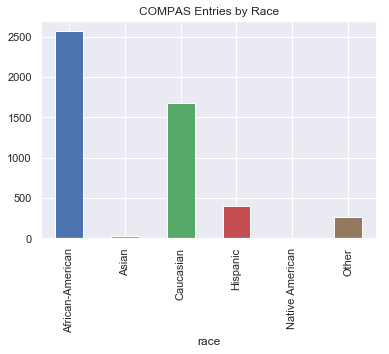

In [165]:
sns.set(font_scale=1)
train_c.groupby(['race']).size().plot(kind = 'bar')
plt.title("COMPAS Entries by Race")
plt.show()

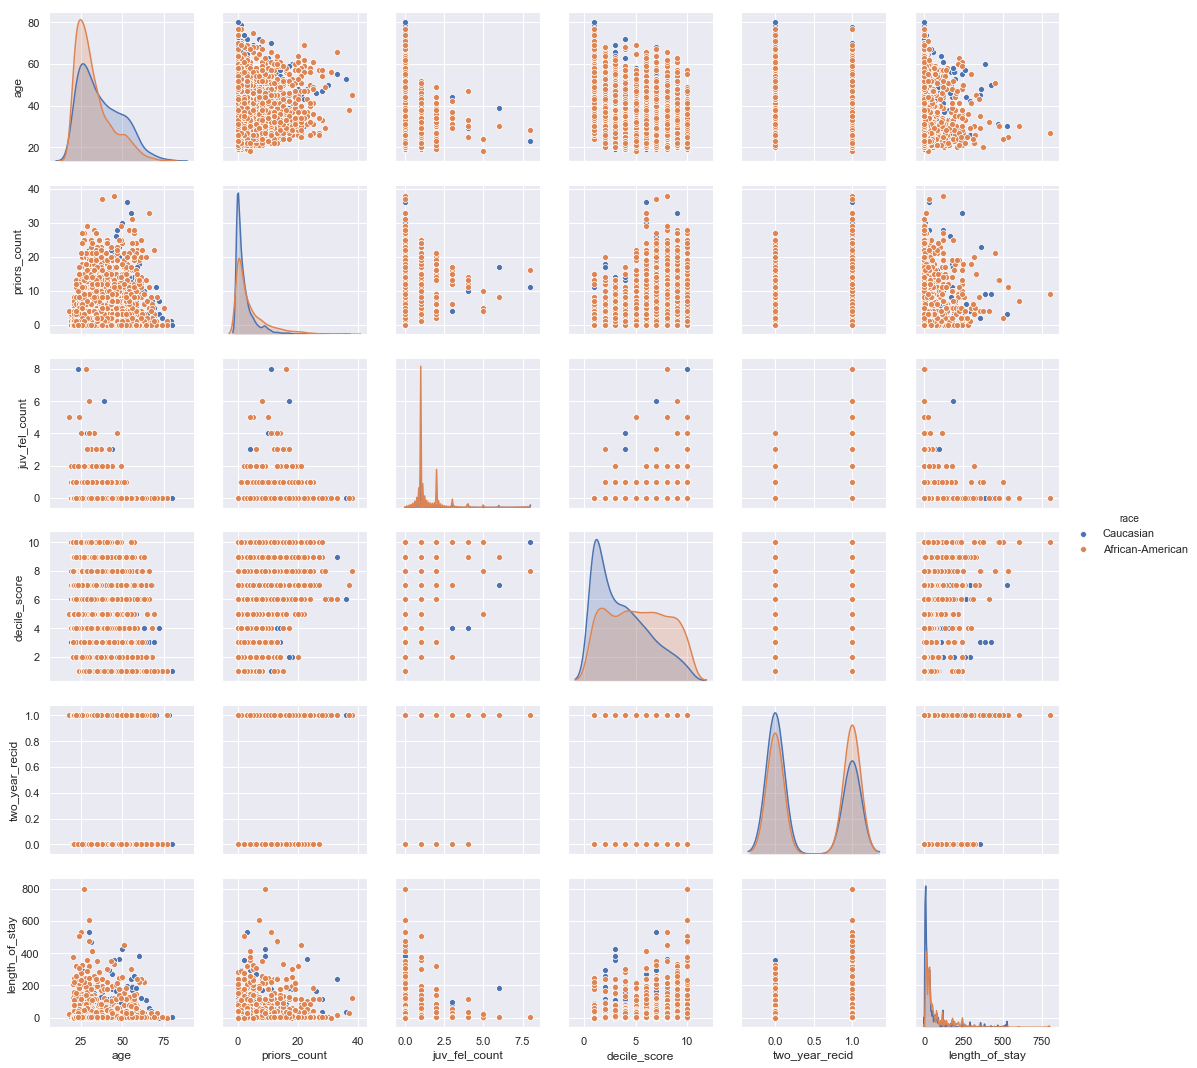

In [163]:
sns.set(font_scale=1)
g=sns.pairplot(plot_data, hue = 'race',vars = ['age','priors_count','juv_fel_count','decile_score',
                                              'two_year_recid','length_of_stay'])


In [188]:
import scipy
t_test_results = {}
# need to remove non-numeric columns
train_c_numeric = train_c.drop(columns = ['c_charge_degree', 'c_charge_desc', 'score_text', 'sex']) 
AA_df = train_c_numeric.where(train_c_numeric['race']== "African-American").dropna().drop(columns = ["race"])
C_df = train_c_numeric.where(train_c_numeric['race']== "Caucasian").dropna()


for x in AA_df.columns:
    AA_df2 = AA_df[:][x]
    C_df2 = C_df[:][x]
    t_test_results[x] = scipy.stats.ttest_ind(AA_df2,C_df2)
    
t_test_train_df = pd.DataFrame.from_dict(t_test_results,orient='Index')
t_test_train_df.columns = ['field','pvalue']
t_test_train_df.sort_values('pvalue')


,field,pvalue
decile_score,18.489343,1.807588e-73
age,-13.098914,1.845587e-38
priors_count,12.753788,1.384207e-36
priors_5plus,11.808851,1.095944e-31
two_year_recid,7.617380,3.172617e-14
juv_misd_1plus,7.397920,1.658451e-13
juv_fel_1plus,6.780066,1.366583e-11
juv_misd_count,5.942367,3.034767e-09
juv_fel_count,4.703315,2.641083e-06
juv_other_1plus,4.359657,1.333534e-05


**4.3 With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences? Explain in 3-5 sentences.**

**Decile score:** This can be based on a survey with factors that have an underlying element of systemic racism. 

**Age:** African American defendants tend to be significantly younger than Caucasian defendants. This is likely due to overpolicing in certain areas where African American people are growing up, whereas Caucasian defendants are likely more shielded from this policing until they are older. 

**Priors_count:** This is related to overpolicing and age. If African American defendants are younger, then that will give more time to allow for more priors over time; Alternatively, Caucasian people tend to be older in the data, so they likely are not receiving priors from a younger age. 

**4.4. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models:  $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor.**

In [198]:
train_c_final = pd.get_dummies(train_c, 
                               columns=["race", 'sex', 'score_text', 'c_charge_degree'])
test_c_final = pd.get_dummies(test_c, 
                               columns=["race", 'sex', 'score_text', 'c_charge_degree'])


y_train_c = train_c_final['two_year_recid']
X_train_c= train_c_final.drop(columns = ['c_charge_desc','two_year_recid'])
y_test_c = test_c_final['two_year_recid']
X_test_c= test_c_final.drop(columns = ['c_charge_desc','two_year_recid'])

In [209]:
lr = LogisticRegression(C=100000000)
lr.fit(X_train_c, y_train_c)

y_hat_c_train_log = lr.predict(X_train_c)
print("Training Accuracy:", accuracy_score(y_train_c, y_hat_c_train_log))

y_hat_c_test_log = lr.predict(X_test_c)
print("Test Accuracy:", accuracy_score(y_test_c, y_hat_c_test_log))

Training Accuracy: 0.6935385861859429
Test Accuracy: 0.682591093117409


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [201]:
X_train_c_array = X_train_c.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_c_scaled = min_max_scaler.fit_transform(X_train_c_array)
normalized_X_c_train = pd.DataFrame(x_c_scaled)
normalized_X_c_train.columns = X_train_c.columns

X_test_c_array = X_test_c.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_c_scaled = min_max_scaler.fit_transform(X_test_c_array)
normalized_X_c_test = pd.DataFrame(x_c_scaled)
normalized_X_c_test.columns = X_test_c.columns

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [211]:
#Lasso 

lasso = Lasso(random_state=0, max_iter=10000)
model_lasso_c = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(normalized_X_c_train, y_train_c)

coef_dict = {}
for coef, feat in zip(model_lasso_c.coef_,normalized_X_c_train.columns):
    coef_dict[feat] = coef


y_c_hat_train_lasso = model_lasso_c.predict(normalized_X_c_train)
y_c_hat_test_lasso = model_lasso_c.predict(normalized_X_c_test)

print("Training Accuracy:", accuracy_score(y_train_c, np.round(y_c_hat_train_lasso)))
print("Test Accuracy:", accuracy_score(y_test_c, np.round(y_c_hat_test_lasso)))
print("Lasso picked " + str(sum(model_lasso_c.coef_ != 0)) + 
      " variables and eliminated the other " +  str(sum(model_lasso_c.coef_ == 0)) + 
      " variables")

Training Accuracy: 0.6880696779420701
Test Accuracy: 0.6777327935222672
Lasso picked 17 variables and eliminated the other 13 variables


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [239]:
model_df = pd.DataFrame(model_lasso_c.coef_)
model_df = model_df.set_index(X_train_c.columns)
model_df

,0
age,-2.950308e-01
priors_count,2.365516e-01
juv_fel_count,0.000000e+00
juv_misd_count,-0.000000e+00
juv_other_count,0.000000e+00
decile_score,2.216658e-01
length_of_stay,-0.000000e+00
priors_1,4.045089e-02
priors_234,1.431195e-01
priors_5plus,2.071703e-01


Classification Report for: Logarithmic
              precision    recall  f1-score   support

           0       0.69      0.77      0.73       674
           1       0.68      0.57      0.62       561

   micro avg       0.68      0.68      0.68      1235
   macro avg       0.68      0.67      0.67      1235
weighted avg       0.68      0.68      0.68      1235

Classification Report for: Lasso
              precision    recall  f1-score   support

           0       0.68      0.76      0.72       674
           1       0.67      0.58      0.62       561

   micro avg       0.68      0.68      0.68      1235
   macro avg       0.68      0.67      0.67      1235
weighted avg       0.68      0.68      0.67      1235



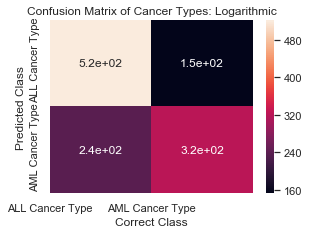

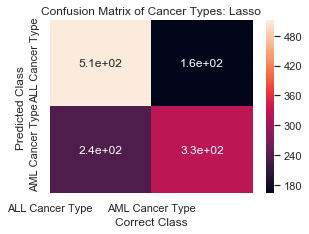

In [215]:
labels = ("Logarithmic",'Lasso')
y_hat_vals = (y_hat_c_test_log, y_c_hat_test_lasso)
nums = [1,2]

for x,y,z in zip(labels,y_hat_vals, nums):
    create_confusion_matrix(x, y_test_c,y,z)

**4.5. Refit the models in 4.4 without race as a predictor. Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set. How do these compare to the models when race is included as a predictor?**

In [219]:
X_train_c_norace= X_train_c.drop(columns = [ 'race_African-American', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other',])
X_test_c_norace= X_test_c.drop(columns = [ 'race_African-American', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other',])
normalized_X_c_train_norace= normalized_X_c_train.drop(columns = [ 'race_African-American', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other',])
normalized_X_c_test_norace= normalized_X_c_test.drop(columns = [ 'race_African-American', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other',])

In [224]:
lr = LogisticRegression(C=100000000)
lr.fit(X_train_c_norace, y_train_c)

y_hat_c_train_log_norace = lr.predict(X_train_c_norace)
print("Training Accuracy:", accuracy_score(y_train_c, y_hat_c_train_log_norace))

y_hat_c_test_log_norace = lr.predict(X_test_c_norace)
print("Test Accuracy:", accuracy_score(y_test_c, y_hat_c_test_log_norace))

Training Accuracy: 0.6933360340287624
Test Accuracy: 0.682591093117409


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [223]:
#Lasso 

lasso = Lasso(random_state=0, max_iter=10000)
model_lasso_c_norace = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(normalized_X_c_train_norace, y_train_c)

coef_dict = {}
for coef, feat in zip(model_lasso_c_norace.coef_,normalized_X_c_train_norace.columns):
    coef_dict[feat] = coef


y_c_hat_train_lasso_norace = model_lasso_c_norace.predict(normalized_X_c_train_norace)
y_c_hat_test_lasso_norace = model_lasso_c_norace.predict(normalized_X_c_test_norace)

print("Training Accuracy:", accuracy_score(y_train_c, np.round(y_c_hat_train_lasso_norace)))
print("Test Accuracy:", accuracy_score(y_test_c, np.round(y_c_hat_test_lasso_norace)))
print("Lasso picked " + str(sum(model_lasso_c_norace.coef_ != 0)) + 
      " variables and eliminated the other " +  str(sum(model_lasso_c_norace.coef_ == 0)) + 
      " variables")

Training Accuracy: 0.6905003038282358
Test Accuracy: 0.674493927125506
Lasso picked 16 variables and eliminated the other 8 variables


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Classification Report for: Logarithmic
              precision    recall  f1-score   support

           0       0.69      0.77      0.73       674
           1       0.68      0.57      0.62       561

   micro avg       0.68      0.68      0.68      1235
   macro avg       0.68      0.67      0.67      1235
weighted avg       0.68      0.68      0.68      1235

Classification Report for: Lasso
              precision    recall  f1-score   support

           0       0.68      0.75      0.72       674
           1       0.66      0.58      0.62       561

   micro avg       0.67      0.67      0.67      1235
   macro avg       0.67      0.67      0.67      1235
weighted avg       0.67      0.67      0.67      1235



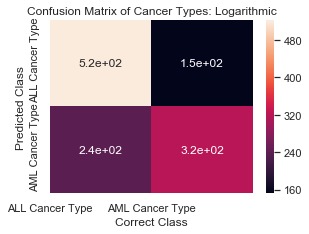

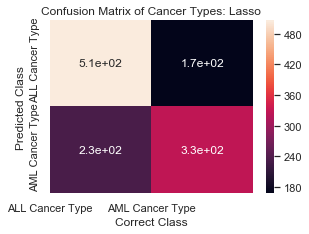

In [225]:
labels = ("Logarithmic",'Lasso')
y_hat_vals = (y_hat_c_test_log_norace, y_c_hat_test_lasso_norace)
nums = [1,2]

for x,y,z in zip(labels,y_hat_vals, nums):
    create_confusion_matrix(x, y_test_c,y,z)

**4.6. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.**

I ran the lasso model because I was curious to see if the model would actually remove race from the model due to collinearity with other features. This turned out to be the case for African Americans but not for Caucasians. So we know from the beginning that race is likely picked up in some of the other variables (or many of the other variables). Given this, it will be very difficult to find a way to create an unbiased model. 

However, I would want to know how the model performs relative to regular judges. There are many known systemic issues in the criminal justice system, and this model may provide a chance to start being more objective about the factors leading to systemic racism and harsher sentencing. This model should be seen as a starting point and improved upon once we know the results of earlier cases.

---